In [1]:
%pip install lightgbm
%pip install pytorch_tabular
%pip install shap

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/453.1 kB ? eta -:--:--
   ---------------------------- ----------- 317.4/453.1 kB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 453.1/453.1 kB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------------- ------------------------- 0.9/2.6 MB 19.8 MB/s eta 0:00:01
   --------------------------- ------------ 1.9/2.6 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 21.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 15.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
    --------------------------------------- 0.5/28.1 MB 16.8 MB/s eta 0:00:02
   - -------------------------------------- 1.4/28.1 MB 14.4 MB/s eta 0:00:02
   --- ---------------------------

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Tabular for the neural network
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, ModelConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models import CategoryEmbeddingModelConfig
import shap

In [3]:
# Load the dataset
data = pd.read_csv('../Dataset/dataset_final.csv')

# Drop unnecessary columns
data = data.drop(['patient_id', 'window_period', 'Sleep_Agitation', 'Physio_Agitation', 'agitation_sleep'], axis=1)
#drop redundant rows
data = data.drop_duplicates()

In [13]:
data.shape

(570, 16)

In [5]:
data[data['Agitation'] == 1].shape[0] / data.shape[0]

0.2912280701754386

In [21]:
# Separate features and target
X = data.drop('Agitation', axis=1)
y = data['Agitation']

# Split the data into train, validation, and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)  # Split off the test set

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=(1 - y.mean()), use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(is_unbalance=True),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

results_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Precision', 'Recall', 'Weighted F1 Score', 'ROC AUC'])

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    result = {
        'Model Name': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Weighted F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    }
    result_df = pd.DataFrame([result])
    results_df = pd.concat([results_df, result_df], ignore_index=True)

# Print results in a tabular format
print(results_df.to_string(index=False))

C:\Users\ACER\AppData\Local\Temp\ipykernel_1544\2339556628.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_df], ignore_index=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 116, number of negative: 283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1449
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290727 -> initscore=-0.891857
[LightGBM] [Info] Start training from score -0.891857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [22]:
results_df

,Model Name,Accuracy,Precision,Recall,Weighted F1 Score,ROC AUC
0,Random Forest,0.941520,0.844828,0.98,0.942687,0.973140
1,Gradient Boosting,0.935673,0.830508,0.98,0.937086,0.977851
2,XGBoost,0.929825,0.839286,0.94,0.930919,0.968760
3,LightGBM,0.923977,0.824561,0.94,0.925331,0.965950
4,Extra Trees,0.935673,0.842105,0.96,0.936819,0.970909


In [40]:
y_pred = classifiers['LightGBM'].predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       121
           1       0.82      0.94      0.88        50

    accuracy                           0.92       171
   macro avg       0.90      0.93      0.91       171
weighted avg       0.93      0.92      0.93       171



In [23]:
# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create an empty DataFrame to store results
k_fold_results_df = pd.DataFrame(columns=['Model', 'Mean F1 Score after 10-fold CV'])

# Iterate over each classifier
for model_name, classifier in classifiers.items():
    
    # Define the weighted F1 scorer
    weighted_f1_scorer = make_scorer(f1_score, average='weighted')
    
    # Perform cross-validation using weighted F1 score
    cv_scores = cross_val_score(classifier, X, y, cv=skf, scoring=weighted_f1_scorer)
    
    # Store results in the DataFrame
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Mean F1 Score after 10-fold CV': [cv_scores.mean()]
    })
    k_fold_results_df = pd.concat([k_fold_results_df, new_row], ignore_index=True)

# Display the results
print(k_fold_results_df)

C:\Users\ACER\AppData\Local\Temp\ipykernel_1544\3123805680.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  k_fold_results_df = pd.concat([k_fold_results_df, new_row], ignore_index=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 150, number of negative: 363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 513, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292398 -> initscore=-0.883768
[LightGBM] [Info] Start training from score -0.883768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [24]:
k_fold_results_df

,Model,Mean F1 Score after 10-fold CV
0,Random Forest,0.959264
1,Gradient Boosting,0.959411
2,XGBoost,0.950562
3,LightGBM,0.963388
4,Extra Trees,0.959651


              precision    recall  f1-score   support

           0       0.97      0.92      0.94       121
           1       0.82      0.94      0.88        50

    accuracy                           0.92       171
   macro avg       0.90      0.93      0.91       171
weighted avg       0.93      0.92      0.93       171



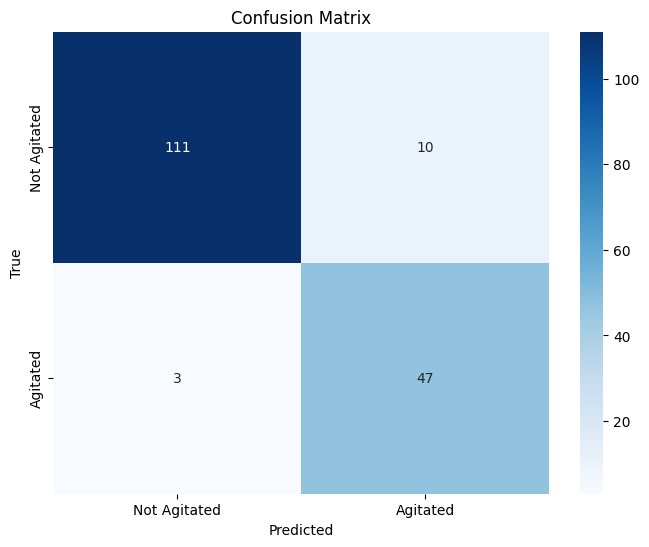

In [41]:
y_pred = classifiers['LightGBM'].predict(X_test)
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Agitated', 'Agitated'], 
            yticklabels=['Not Agitated', 'Agitated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# SHAP Analysis

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


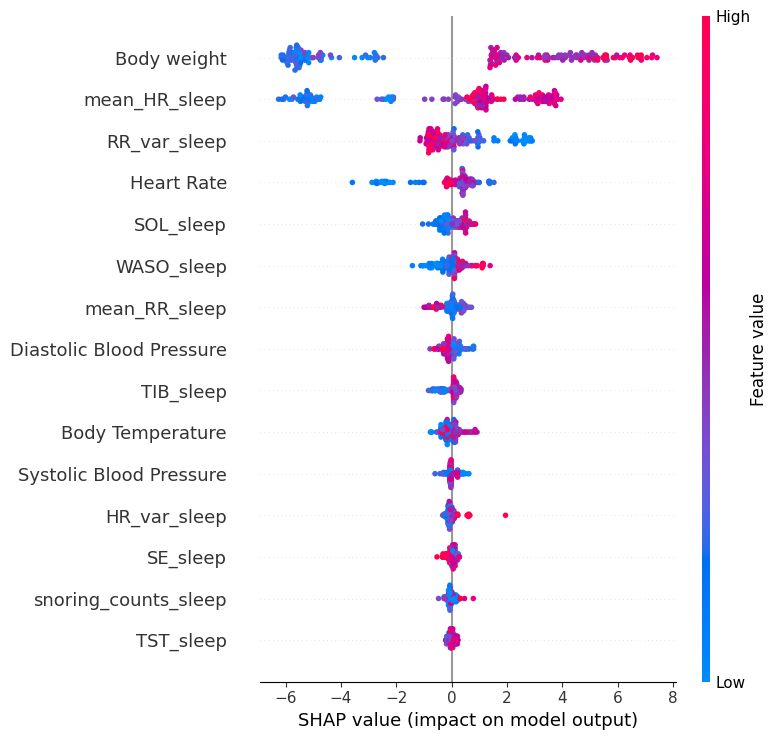

In [42]:
import shap

# Initialize the SHAP Explainer using the tree explainer for tree-based models
explainer = shap.TreeExplainer(classifiers['LightGBM'])

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, plot_type="dot")

In [14]:
print("Type of shap_values object:", type(shap_values))
print("Length of shap_values list:", len(shap_values))
print("Shape of SHAP values for class 0:", shap_values[0].shape)
print("Shape of SHAP values for class 1:", shap_values[1].shape)
print("Shape of X_test data:", X_test.shape)

Type of shap_values object: <class 'shap._explanation.Explanation'>
Length of shap_values list: 114
Shape of SHAP values for class 0: (16, 2)
Shape of SHAP values for class 1: (16, 2)
Shape of X_test data: (114, 16)


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


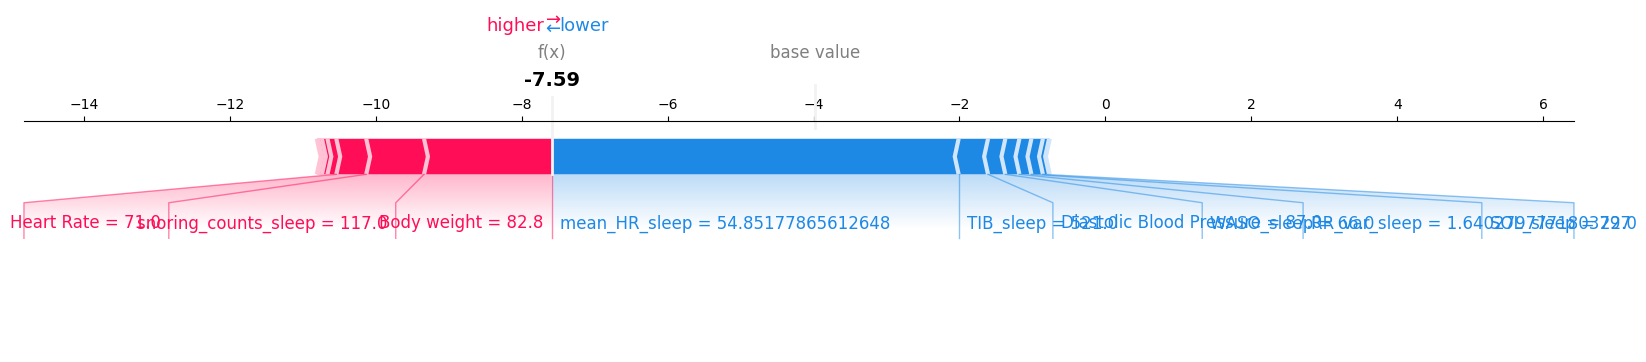

In [62]:
# Select a specific instance (e.g., the first one in the test set)
instance_index = 0  # or any index of interest
single_record = X_test.iloc[instance_index:instance_index+1]

# Calculate SHAP values for the selected instance
shap_values_single = explainer.shap_values(single_record)

# Generate a force plot for the selected instance
shap.force_plot(
    base_value=explainer.expected_value, # the reference value that the features start from
    shap_values=shap_values_single,      # SHAP values for the selected instance
    features=single_record,              # the selected instance's feature values
    matplotlib=True                      # set to True to render it as matplotlib figure
)

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py:696: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


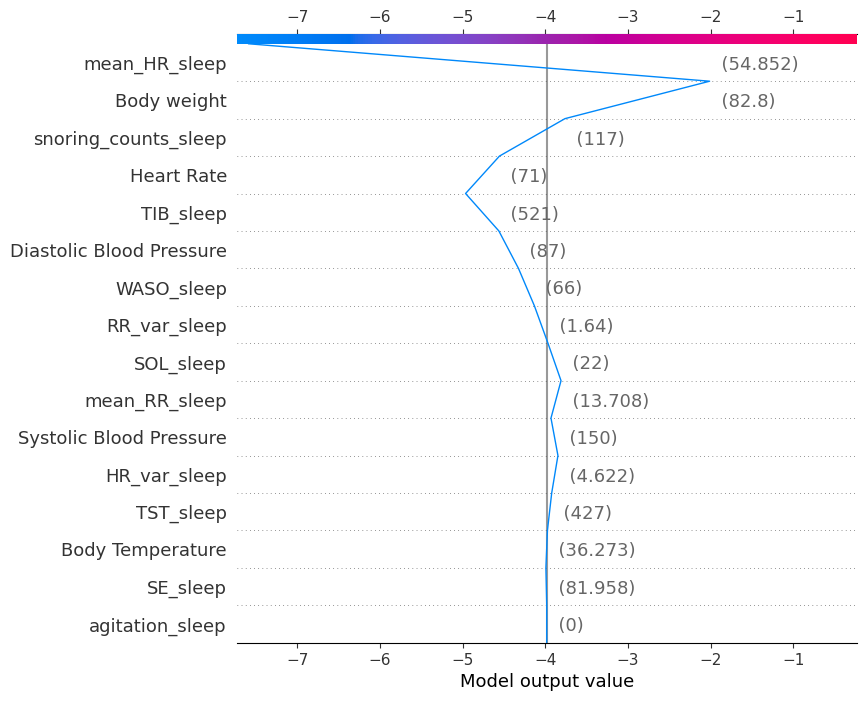

In [40]:
# Calculate SHAP values for the selected instance, if not already calculated
shap_values_single = explainer.shap_values(single_record)

# Make a decision plot for the selected instance
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values_single,
    features=single_record,
    # You may also include feature_names as a parameter if your DataFrame doesn't have column names
    feature_names=X_test.columns.tolist()
)

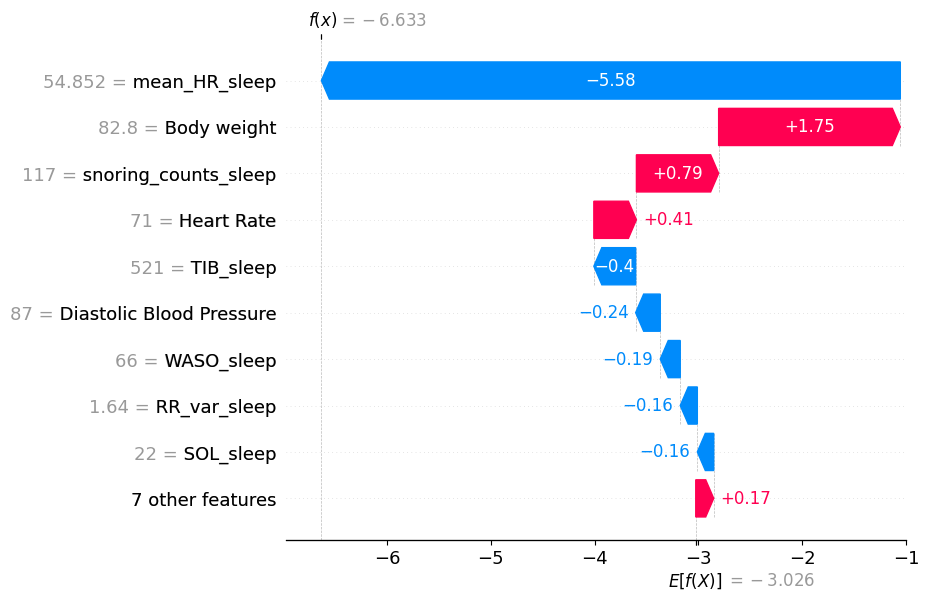

In [47]:
# Generate a waterfall plot for the selected instance
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_single[0], # Use [0] or [1] for binary classification, depending on the class of interest
        base_values=explainer.expected_value,
        data=single_record.values[0], # Convert to array if necessary
        feature_names=X_test.columns.tolist()
    )
)

# Tabular Neural Network

In [13]:
# Adding a Tabular Neural Network
data_config = DataConfig(
    target=['Agitation'],
    continuous_cols=X_train.columns.tolist(),
    categorical_cols=[],
)

model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="512-256-128",
    activation="ReLU",
)

trainer_config = TrainerConfig(
    auto_lr_find=True,
    batch_size=64,
    max_epochs=50,
    gpus=0,
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=OptimizerConfig(),
    trainer_config=trainer_config,
    experiment_config=None
)

# Fit the model using training and validation sets
tabular_model.fit(train=X_train, validation=X_val)

TypeError: TrainerConfig.__init__() got an unexpected keyword argument 'gpus'

In [ ]:
# Evaluate on the test set
evaluation = tabular_model.evaluate(X_test)
predictions = tabular_model.predict(X_test)
predictions_proba = tabular_model.predict_proba(X_test)

# Adding results of the Tabular Neural Network
results['Tabular Neural Network'] = {
    'accuracy': accuracy_score(y_test, predictions['prediction']),
    'precision': precision_score(y_test, predictions['prediction']),
    'recall': recall_score(y_test, predictions['prediction']),
    'f1_score': f1_score(y_test, predictions['prediction']),
    'roc_auc': roc_auc_score(y_test, predictions_proba[:, 1])
}
print(f"Tabular Neural Network - Accuracy: {results['Tabular Neural Network']['accuracy']}, ROC AUC: {results['Tabular Neural Network']['roc_auc']}, F1 score: {results['Tabular Neural Network']['f1_score']}, Precision: {results['Tabular Neural Network']['precision']}, Recall: {results['Tabular Neural Network']['recall']}")